# KE5105 - Building Electrical Consumption Forecasting

# Modelling 2 - Preliminary model

## Summary of Findings
* LOCF model
	* validation MAE (normalised) = **2.294** (**0.0334**)
* Base 1x16 GRU model
	* min validation MAE = 1.682 (0.0223) @ epoch 349
* Base mask 1x16 GRU model
	* min validation MAE = 1.740 (0.0254) @ epoch 230

## Load libraries

In [1]:
import os
os.chdir(os.path.join(os.path.sep, 'home', 'tkokkeng', 'Documents', 'KE5105', 'ETL'))
os.getcwd()

'/home/tkokkeng/Documents/KE5105/ETL'

In [2]:
import sys
if os.path.join(os.getcwd(), 'source') not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'source'))
sys.path

['/home/tkokkeng/python/python367/tsfvenv/lib/python36.zip',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages',
 '/home/tkokkeng/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/IPython/extensions',
 '/home/tkokkeng/.ipython',
 '/home/tkokkeng/Documents/KE5105/ETL/source']

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import pickle
import numpy as np
import datetime
import myUtilities as mu

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from keras.models import Sequential, load_model
from keras import layers
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, TensorBoard

Using TensorFlow backend.


## Load data for building AS5

In [4]:
as5_train = mu.load_data_by_bldg(['AS5'], 'imputed_train')

In [5]:
as5_train[0][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31616 entries, 2015-06-12 08:00:00 to 2017-03-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         30018 non-null float64
PWMEXTAS4ExBldg                   30018 non-null float64
PWMAS4LanguageCenter              30018 non-null float64
PWMCANTEEN                        30018 non-null float64
PWMStreetLight                    30018 non-null float64
BTUAS5                            30029 non-null float64
PWMMainIC_30min_avg               29985 non-null float64
PWMEXTAS4ExBldg_30min_avg         29985 non-null float64
PWMAS4LanguageCenter_30min_avg    29985 non-null float64
PWMCANTEEN_30min_avg              29985 non-null float64
PWMStreetLight_30min_avg          29985 non-null float64
BTUAS5_30min_avg                  29998 non-null float64
PWM_sumadd                        29985 non-null float64
PWM_sumsubtract                   29985 non-null float64
PWM_30min_avg                     30027 non-null float64
B

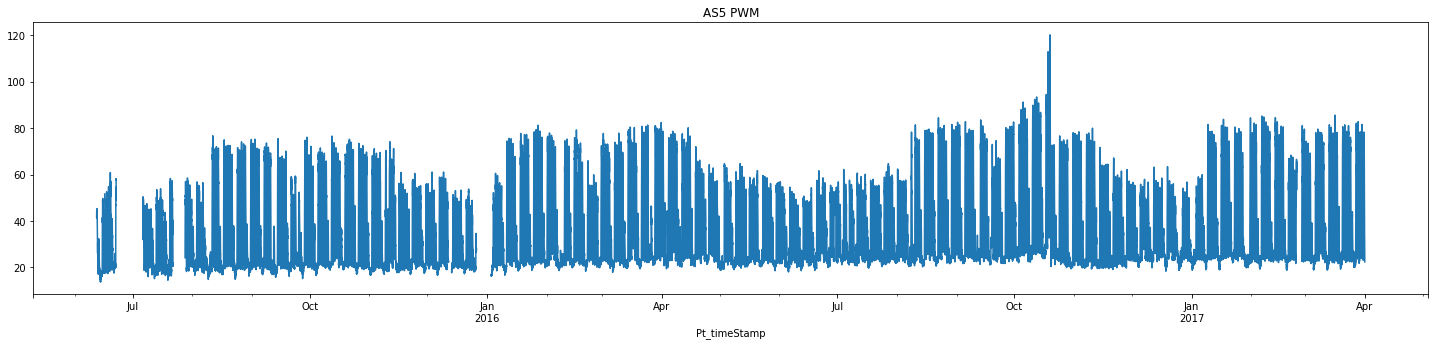

In [6]:
as5_train_df = as5_train[0][1]
as5_train_df['PWM_30min_avg'].plot(figsize=(25, 5), title='AS5 PWM')

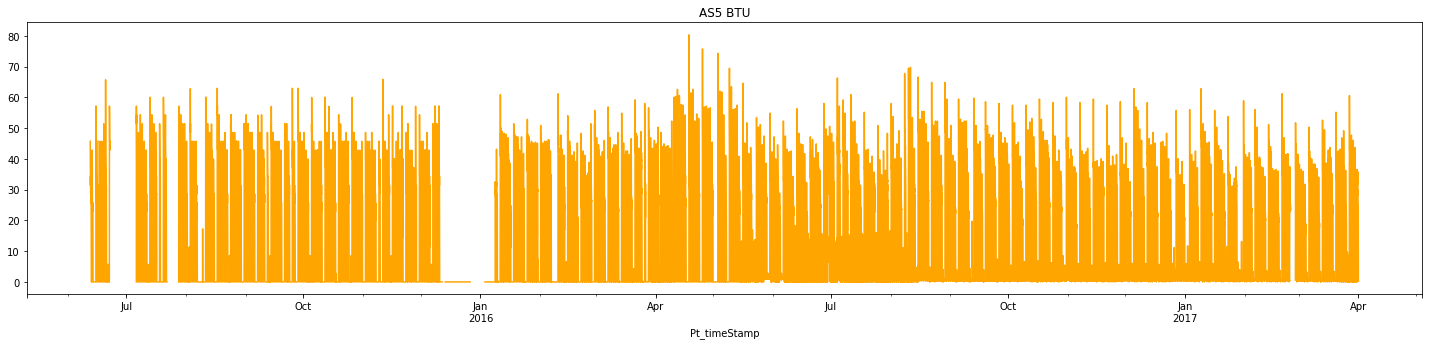

In [7]:
as5_train_df['BTU_30min_avg'].plot(figsize=(25, 5), title='AS5 BTU', color='orange')

## Split a validation set out from the training set

In [8]:
as5_train_split_df = as5_train_df[:20000]
as5_val_split_df = as5_train_df[20000:]

In [9]:
print('train split = %s\nvalidation split = %s' % (as5_train_split_df.shape, as5_val_split_df.shape))

train split = (20000, 17)
validation split = (11616, 17)


## Transform the training data
* Normalise the data - convert PWM and BTU values into the range 0 to 1
* Replace NaN with -1

In [10]:
# Create a transformation pipleline to prepare the training dataset for RNN.
attrbs = ['PWM_30min_avg', 'BTU_30min_avg']
my_pipeline = Pipeline([
    ('selector', mu.DataFrameSelector(attrbs)),
    ('minmax_scaler', MinMaxScaler()),
    ('na_transform', mu.Nan_to_Num_Transformer())
])

In [11]:
as5_train_data = my_pipeline.fit_transform(as5_train_split_df)
as5_train_data

array([[0.40696488, 0.56924225],
       [0.41425033, 0.53427896],
       [0.43450386, 0.53353241],
       ...,
       [0.15255719, 0.02140102],
       [0.16873088, 0.0390693 ],
       [0.15503424, 0.00348389]])

In [12]:
as5_train_data.shape

(20000, 2)

Text(0.5, 1.0, 'Normalised PWM Training Data')

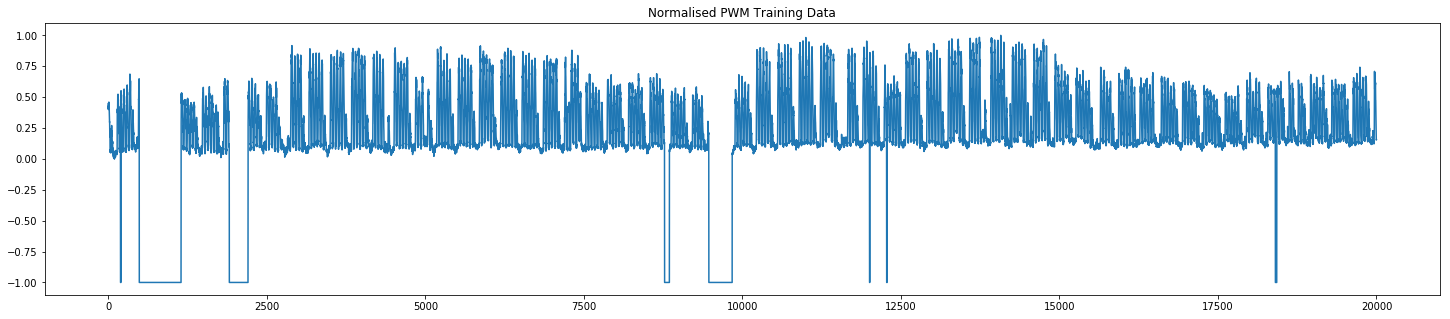

In [13]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0])
plt.title('Normalised PWM Training Data')

Text(0.5, 1.0, 'Normalised BTU Training Data')

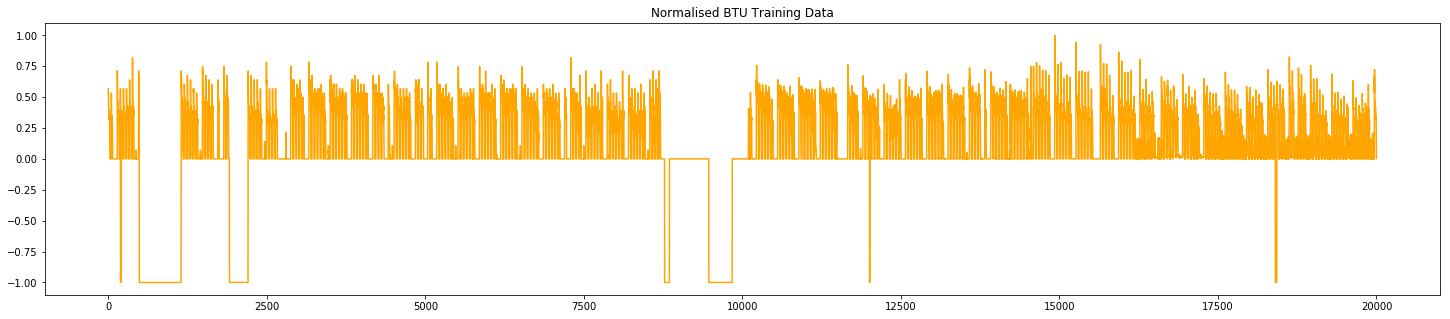

In [14]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 1], color='orange')
plt.title('Normalised BTU Training Data')

In [15]:
as5_val_data = my_pipeline.transform(as5_val_split_df)
as5_val_data

array([[1.52120064e-01, 2.15842164e-20],
       [1.56199913e-01, 2.15842164e-20],
       [1.60716888e-01, 1.99328108e-01],
       ...,
       [1.99912575e-01, 3.22259550e-02],
       [1.59842634e-01, 3.48388702e-03],
       [1.25570108e-01, 3.46599347e-03]])

In [16]:
as5_val_data.shape

(11616, 2)

Text(0.5, 1.0, 'Normalised PWM Validation Data')

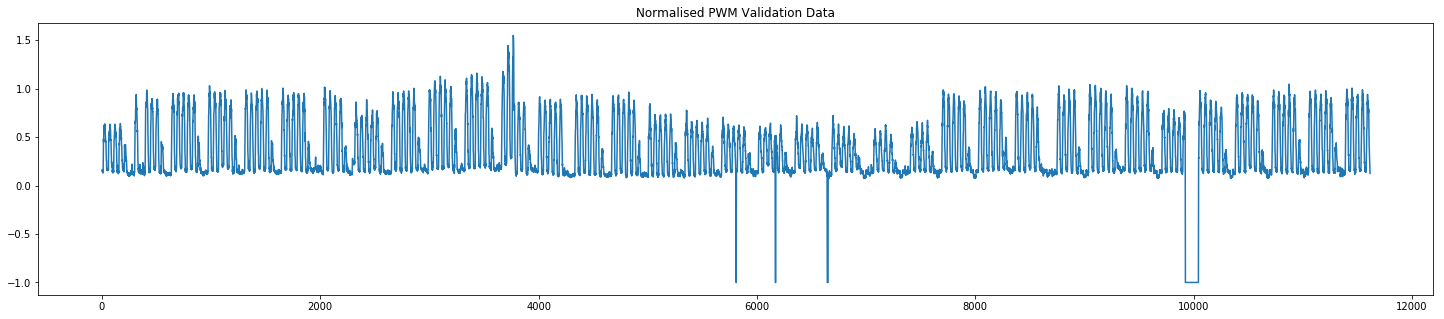

In [17]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_val_data.shape[0]), as5_val_data[:, 0])
plt.title('Normalised PWM Validation Data')

Text(0.5, 1.0, 'Normalised BTU Validation Data')

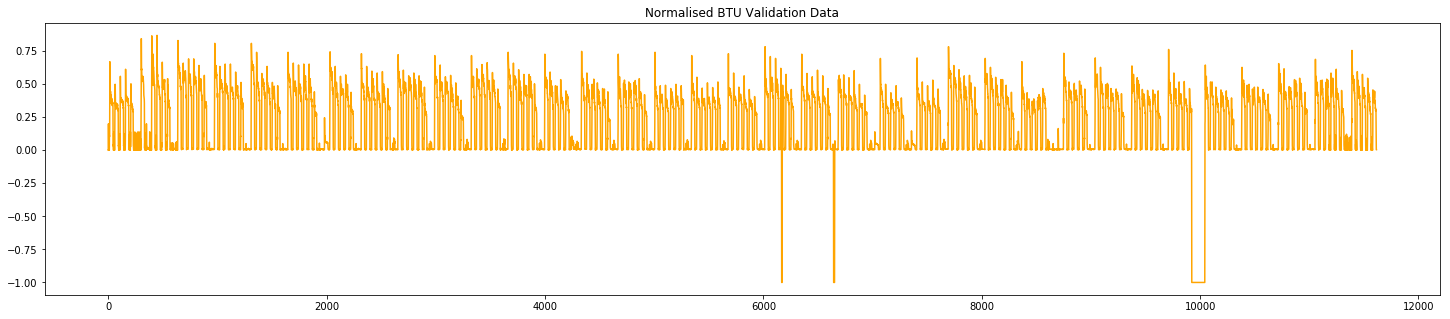

In [18]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_val_data.shape[0]), as5_val_data[:, 1], color='orange')
plt.title('Normalised BTU Validation Data')

## Parameters for the RNN model

Also used for generating the datasets with the lagged values 

In [19]:
lookback = 240  # 5 days; each day has 48 observations
step = 1  # sampling rate used for the lookback period
delay = 0  # 1 step ahead prediction
batch_size = 128

## Calculate the MAE for a Simple Last Observation Carry Forward (LOCF) Model

In [20]:
as5_val_data.shape

(11616, 2)

In [21]:
# Generators for the train and test sets.
gen_locf_val = mu.generator(as5_val_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_data)-1,
                            batch_size=batch_size, step=step)

In [22]:
val_steps = int(np.ceil((len(as5_val_data) - lookback - delay) / batch_size))
val_steps

89

In [23]:
# Calculate a simple baseline for model accuracy using MAE. Baseline model predicts label at t as label at t-1
# (LOCF last observation carry forward)
batch_maes = []
locf_preds = []

for a_step in range(val_steps):
    samples, targets = next(gen_locf_val)
    a_pred = samples[:, -1, 0]
    locf_preds.append(a_pred)
    mae = np.nanmean(np.abs(a_pred - targets))
    batch_maes.append(mae)
print('Normalised LOCF MAE = %f' % (np.nanmean(batch_maes)))


Normalised LOCF MAE = 0.033431


In [24]:
print('LOCF MAE = %f' % (np.nanmean(batch_maes) * (as5_train_split_df['PWM_30min_avg'].max() - as5_train_split_df['PWM_30min_avg'].min())))

LOCF MAE = 2.294355


In [25]:
# For plotting later.
locf_preds = np.concatenate(locf_preds)

## Base RNN Model

### Test the thread-safe data generator

In [26]:
gen_testing = mu.DataGenerator(as5_train_data[:1000],
                               lookback=lookback, delay=delay, min_index=0, max_index=999,
                               batch_size=batch_size, step=step)

There are 511 samples with missing output values; the number of batches is 1000 - 240 (lookback) - 511 - 0 (delay) / 128 = 1.9453. 2 batches is correct. 

In [27]:
(as5_train_data[240:1000, 0] == -1).sum()

511

In [28]:
gen_testing.__len__()

2

The size of the first mini-batch is correct. 128 samples, each with 240 (lookback) x 2 (PWM & BTU) attributes.

In [29]:
gen_testing.__getitem__(0)[0].shape

(128, 240, 2)

The values of the 2nd sample tally with the values of the 1st sample with a shift of 1.

In [30]:
gen_testing.__getitem__(0)[0][0, :5, :]

array([[0.40696488, 0.56924225],
       [0.41425033, 0.53427896],
       [0.43450386, 0.53353241],
       [0.45169751, 0.53415454],
       [0.39967944, 0.49769815]])

In [31]:
gen_testing.__getitem__(0)[0][1, :5, :]

array([[0.41425033, 0.53427896],
       [0.43450386, 0.53353241],
       [0.45169751, 0.53415454],
       [0.39967944, 0.49769815],
       [0.42896692, 0.42702501]])

The size of the last mini-batch is less than 128. (1000 - 240 - 511) % 128 = 121.

In [32]:
gen_testing.__getitem__(1)[0].shape

(121, 240, 2)

### Train the RNN

In [33]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [34]:
model = Sequential()
model.add(layers.CuDNNGRU(16, input_shape=(None, as5_train_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [35]:
gen_train = mu.DataGenerator(as5_train_data,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                             batch_size=batch_size, step=step, shuffle=True)
gen_val = mu.DataGenerator(as5_val_data,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_data) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 144
test batches = 88


In [36]:
callbacks_list = [
    ModelCheckpoint(
        filepath='base3-1x16gru.best.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    TensorBoard(
        log_dir='tsb_log'
    )
]

In [37]:
histories = []

In [38]:
train_to_epoch = 500
start_epoch = 0
t1 = datetime.datetime.now()
print('Training start time = %s' % t1)
history = model.fit_generator(generator=gen_train, epochs=train_to_epoch,
                              callbacks=callbacks_list,
                              initial_epoch = start_epoch,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))
histories.append(history.history)

Training start time = 2019-03-04 10:13:32.870710

Training Duration = 0:11:51.247127


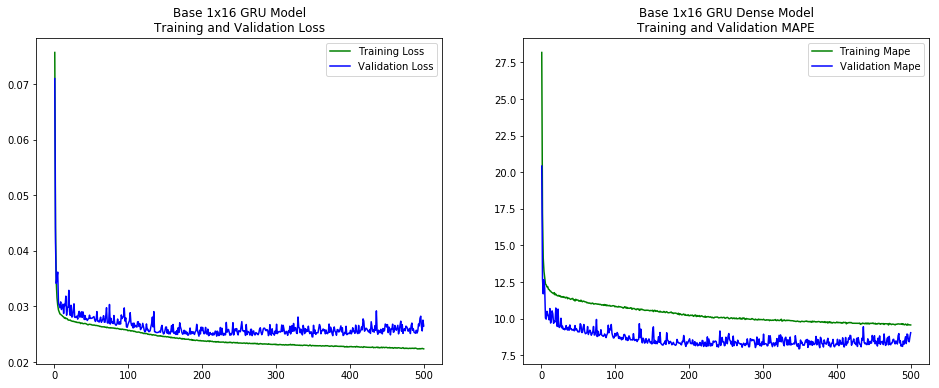

In [39]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in h['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Base 1x16 GRU Model\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('Base 1x16 GRU Dense Model\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [40]:
print('Train min loss = %f\nValidation min loss = %f\nValidation min epoch = %d' %
      (min(train_loss),
       min(val_loss),
       val_loss.index(min(val_loss))))

Train min loss = 0.022345
Validation min loss = 0.024508
Validation min epoch = 349


In [41]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_split_df['PWM_30min_avg'].max() - as5_train_split_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_split_df['PWM_30min_avg'].max() - as5_train_split_df['PWM_30min_avg'].min()))))

Train MAE = 1.533572
Validation MAE = 1.681980


In [42]:
# Load best model
best_model = load_model(os.path.join('models', 'base3-1x16gru.best-epch349.h5'))
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, 16)                960       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 977
Trainable params: 977
Non-trainable params: 0
_________________________________________________________________


In [43]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = best_model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
as5_train_preds.shape

(18317, 1)

In [44]:
as5_train_preds1 = np.concatenate([as5_train_preds, np.zeros((as5_train_preds.shape[0], 1))], axis=1)
as5_train_preds1.shape

(18317, 2)

In [45]:
as5_train_preds1 = my_pipeline.inverse_transform(as5_train_preds1)
as5_train_preds1

array([[ 5.03388748e+01, -1.73472348e-18],
       [ 5.26774109e+01, -1.73472348e-18],
       [ 4.89706327e+01, -1.73472348e-18],
       ...,
       [ 2.39521659e+01, -1.73472348e-18],
       [ 2.35164536e+01, -1.73472348e-18],
       [ 2.41122132e+01, -1.73472348e-18]])

In [46]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if (as5_train_data[i, 0] > mu.MASK_VALUE) and (np.any(as5_train_data[i - lookback:i, 0] > mu.MASK_VALUE)):
        as5_train_preds_withnan[i] = as5_train_preds1[j, 0]
        j += 1
as5_train_preds_withnan.shape

(20000, 1)

In [47]:
gen_val_pred = mu.DataGenerator(as5_val_data,
                                lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_data) - 1,
                                batch_size=batch_size, step=step)
as5_val_preds = best_model.predict_generator(gen_val_pred, workers=3, use_multiprocessing=False)
as5_val_preds.shape

(11236, 1)

In [48]:
as5_val_preds1 = np.concatenate([as5_val_preds, np.zeros((as5_val_preds.shape[0], 1))], axis=1)
as5_val_preds1 = my_pipeline.inverse_transform(as5_val_preds1)
as5_val_preds_withnan = np.full((as5_val_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_val_data)):
    if (as5_val_data[i, 0] > mu.MASK_VALUE) and (np.any(as5_val_data[i - lookback:i, 0] > mu.MASK_VALUE)):
        as5_val_preds_withnan[i] = as5_val_preds1[j, 0]
        j += 1
as5_val_preds_withnan.shape

(11616, 1)

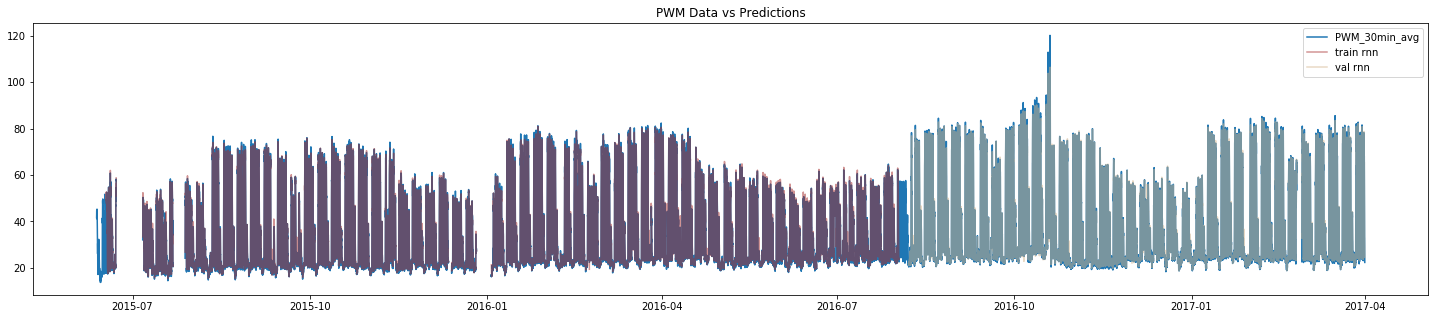

In [49]:
plt.figure(figsize=(25, 5))
plt.plot(as5_train_df['PWM_30min_avg'])
plt.plot(as5_train_df.index[:20000], as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.plot(as5_train_df.index[20000:], as5_val_preds_withnan.flatten(), color='tan', alpha=.5, label='val rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

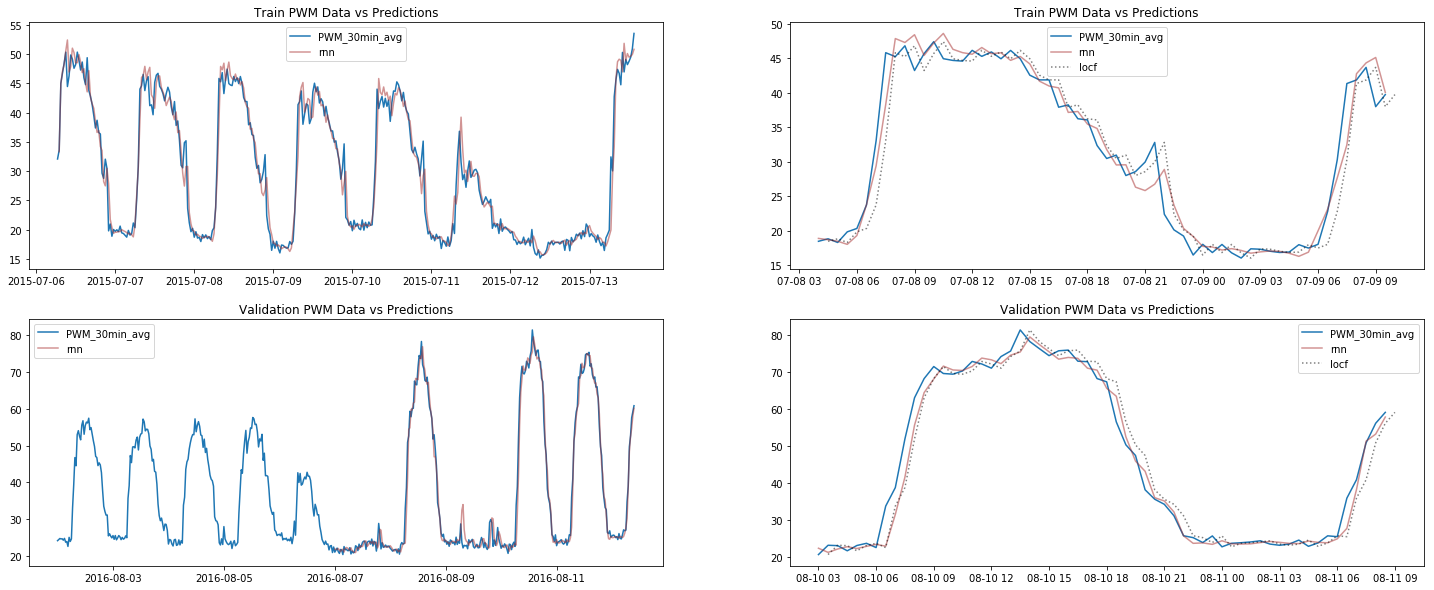

In [50]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(as5_train_df.iloc[1000:1500, as5_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(as5_train_df.index[1000:1500], as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(as5_train_df.iloc[1240:1300, as5_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(as5_train_df.index[1240:1300], as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(as5_train_df.index[1241:1301], as5_train_df.iloc[1240:1300, as5_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(as5_train_df.iloc[20000:20500, as5_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(as5_train_df.index[20000:20500], as5_val_preds_withnan[:500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(as5_train_df.iloc[20390:20450, as5_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(as5_train_df.index[20390:20450], as5_val_preds_withnan[390:450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(as5_train_df.index[20391:20451], as5_train_df.iloc[20390:20450, as5_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [51]:
model.save('base3-1x16gru.h5')

In [52]:
with open('base3-1x16gru-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## Base RNN Model with Mask

In [53]:
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)

In [54]:
gen_train = mu.DataGenerator(as5_train_data,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                             batch_size=batch_size, step=step, shuffle=True)
gen_val = mu.DataGenerator(as5_val_data,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_data) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 144
test batches = 88


In [55]:
model = Sequential()
model.add(layers.Masking(mask_value=-1, input_shape=(None, as5_train_data.shape[-1])))
# Use the GRU variant compatible with CuDNNGRU. CuDNNGRU is not compatible with Masking.
model.add(layers.GRU(16, recurrent_activation='sigmoid', reset_after=True))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, None, 2)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                960       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 977
Trainable params: 977
Non-trainable params: 0
_________________________________________________________________


In [56]:
callbacks_list = [
    ModelCheckpoint(
        filepath='base3-mask-1x16gru.best-epchxxx.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    TensorBoard(
        log_dir='tsb_log'
    )
]

In [57]:
histories = []

In [58]:
train_to_epoch = 500
start_epoch = 0
t1 = datetime.datetime.now()
print('Training start time = %s' % t1)
history = model.fit_generator(generator=gen_train, epochs=train_to_epoch,
                              callbacks=callbacks_list,
                              initial_epoch = start_epoch,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))
histories.append(history.history)

Training start time = 2019-03-04 10:55:49.551554

Training Duration = 3:14:37.003427


In [59]:
model.save('base3-mask-1x16gru-epch' + str(train_to_epoch) + '.h5')

In [60]:
with open('base3-mask-1x16gru-histories-epch' + str(train_to_epoch) + '.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

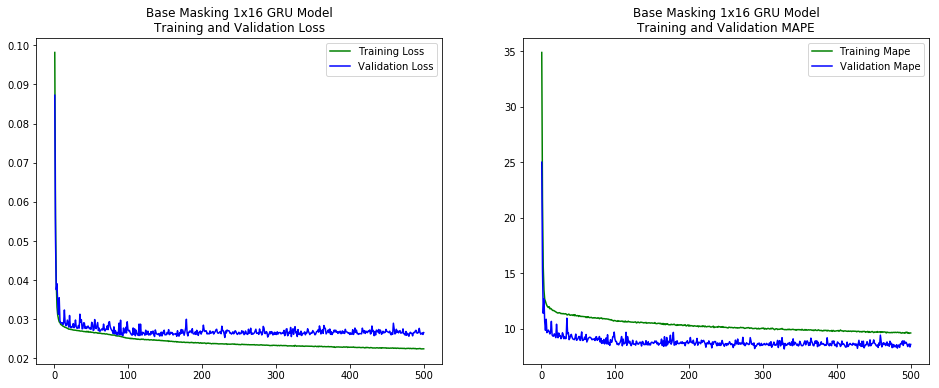

In [61]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in h['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Base Masking 1x16 GRU Model\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('Base Masking 1x16 GRU Model\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [62]:
print('min validation loss = {}\nepoch = {}'.format(min(val_loss), val_loss.index(min(val_loss))))

min validation loss = 0.025351999674341187
epoch = 230


In [63]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_split_df['PWM_30min_avg'].max() - as5_train_split_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_split_df['PWM_30min_avg'].max() - as5_train_split_df['PWM_30min_avg'].min()))))

Train MAE = 1.538495
Validation MAE = 1.739908


In [64]:
# Load best model
best_model = load_model(os.path.join('models', 'base3-mask-1x16gru.best-epch230.h5'))
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, None, 2)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                960       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 977
Trainable params: 977
Non-trainable params: 0
_________________________________________________________________


In [65]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = best_model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
as5_train_preds.shape

(18317, 1)

In [66]:
as5_train_preds1 = np.concatenate([as5_train_preds, np.zeros((as5_train_preds.shape[0], 1))], axis=1)
as5_train_preds1.shape

(18317, 2)

In [67]:
as5_train_preds1 = my_pipeline.inverse_transform(as5_train_preds1)
as5_train_preds1

array([[ 5.20416681e+01, -1.73472348e-18],
       [ 5.32973432e+01, -1.73472348e-18],
       [ 4.83004056e+01, -1.73472348e-18],
       ...,
       [ 2.40103444e+01, -1.73472348e-18],
       [ 2.33574371e+01, -1.73472348e-18],
       [ 2.43475053e+01, -1.73472348e-18]])

In [68]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if (as5_train_data[i, 0] > mu.MASK_VALUE) and (np.any(as5_train_data[i - lookback:i, 0] > mu.MASK_VALUE)):
        as5_train_preds_withnan[i] = as5_train_preds1[j, 0]
        j += 1
as5_train_preds_withnan.shape

(20000, 1)

In [69]:
gen_val_pred = mu.DataGenerator(as5_val_data,
                                lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_data) - 1,
                                batch_size=batch_size, step=step)
as5_val_preds = best_model.predict_generator(gen_val_pred, workers=3, use_multiprocessing=False)
as5_val_preds.shape

(11236, 1)

In [70]:
as5_val_preds1 = np.concatenate([as5_val_preds, np.zeros((as5_val_preds.shape[0], 1))], axis=1)
as5_val_preds1 = my_pipeline.inverse_transform(as5_val_preds1)
as5_val_preds_withnan = np.full((as5_val_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_val_data)):
    if (as5_val_data[i, 0] > mu.MASK_VALUE) and (np.any(as5_val_data[i - lookback:i, 0] > mu.MASK_VALUE)):
        as5_val_preds_withnan[i] = as5_val_preds1[j, 0]
        j += 1
as5_val_preds_withnan.shape

(11616, 1)

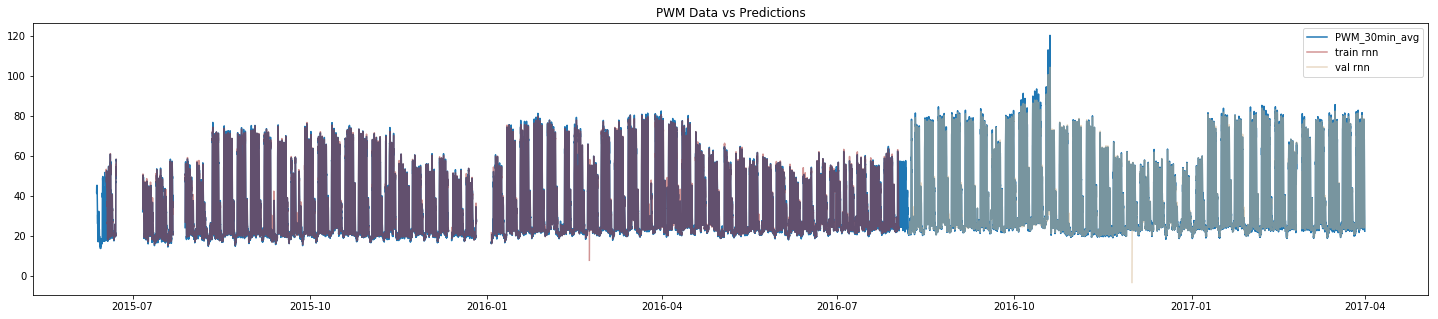

In [71]:
plt.figure(figsize=(25, 5))
plt.plot(as5_train_df['PWM_30min_avg'])
plt.plot(as5_train_df.index[:20000], as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.plot(as5_train_df.index[20000:], as5_val_preds_withnan.flatten(), color='tan', alpha=.5, label='val rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

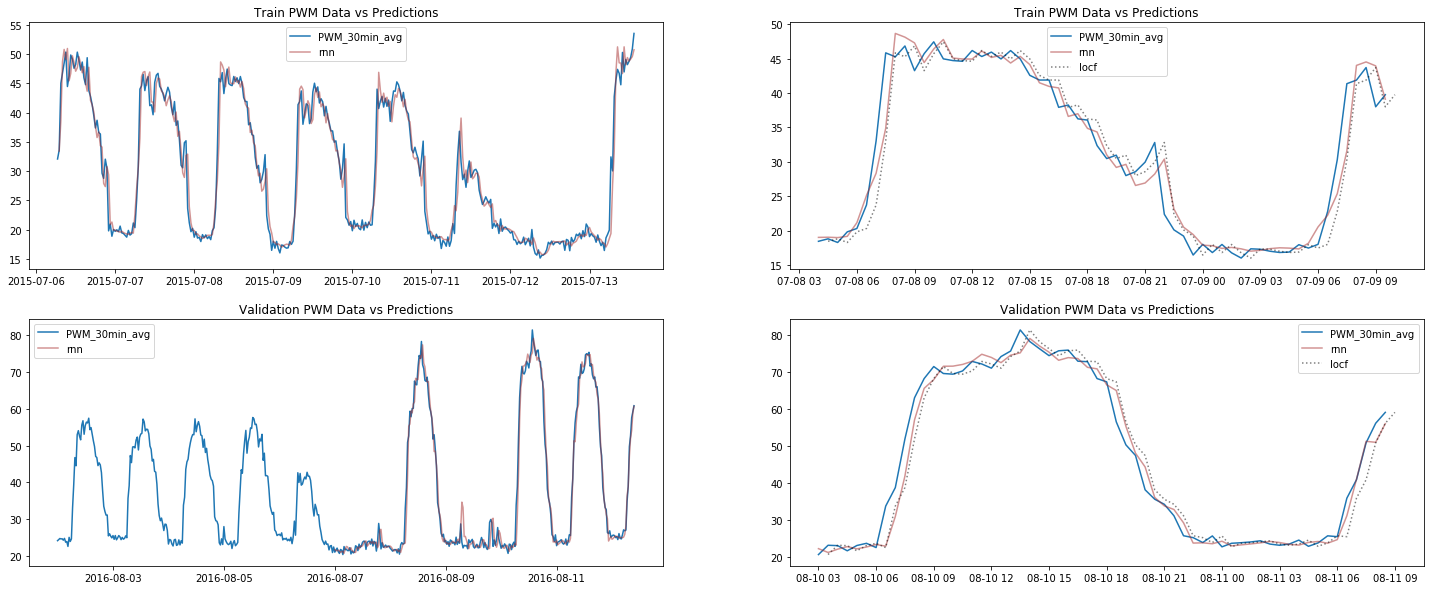

In [72]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(as5_train_df.iloc[1000:1500, as5_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(as5_train_df.index[1000:1500], as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(as5_train_df.iloc[1240:1300, as5_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(as5_train_df.index[1240:1300], as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(as5_train_df.index[1241:1301], as5_train_df.iloc[1240:1300, as5_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(as5_train_df.iloc[20000:20500, as5_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(as5_train_df.index[20000:20500], as5_val_preds_withnan[:500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(as5_train_df.iloc[20390:20450, as5_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(as5_train_df.index[20390:20450], as5_val_preds_withnan[390:450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(as5_train_df.index[20391:20451], as5_train_df.iloc[20390:20450, as5_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1
plt.title('Validation PWM Data vs Predictions')
plt.legend()

## Create the nested cross validation splits

In [57]:
# tscv = TimeSeriesSplit(n_splits=5)
# for train_idx, val_idx in tscv.split(as5_train_data):
#     print("%s %s" % (train_idx, val_idx))

## Nested cross validation

In [58]:
# histories = []
# i = 1
# for train_idx, val_idx in tscv.split(as5_train_data):
# 
#     print('5-fold Nested cross validation iteration', i)
#     gen_train = mu.generator(as5_train_data[train_idx],
#                                   lookback=lookback, delay=delay, min_index=0, max_index=len(train_idx)-1,
#                                   batch_size=batch_size, step=step)    
#     train_steps = ((len(train_idx) - lookback + 1 - delay) // batch_size) + 1
#     gen_val = mu.generator(as5_train_data[val_idx],
#                                   lookback=lookback, delay=delay, min_index=0, max_index=len(val_idx)-1,
#                                   batch_size=batch_size, step=step)    
#     val_steps = ((len(val_idx) - lookback + 1 - delay) // batch_size) + 1
#     history = model.fit_generator(gen_train, steps_per_epoch=train_steps, epochs=30,
#                                   validation_data=gen_val, validation_steps=val_steps, workers=0, use_multiprocessing=False)
#     histories.append(history)
#     i += 1